<a href="https://colab.research.google.com/github/Goshikhar23/DL-back-to-the-basics/blob/master/Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm
import seaborn as sns
from tqdm import tqdm_notebook


In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red", "yellow", "green"])

In [ ]:
np.random.seed(0)

# Generating Data

In [ ]:
iris = load_iris()
data = iris.data[:, :2]  # Only first 2 of the 4 features
labels = iris.target

In [ ]:
print(data.shape, labels.shape)

(150, 2) (150,)


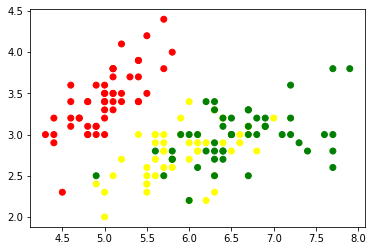

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=my_cmap)
plt.show()

3 classes

Red one can easily be classified(1/3rd accuracy)

# MultiClass Classification

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify= labels, random_state= 0, test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 2) (30, 2) (150,)


In [ ]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


# FFN Class

In [ ]:
class FFN():

  def __init__(self, n_inputs=2, n_outputs=3, hidden_layers = [2], init_method = 'xavier', activation_function= 'sigmoid', leaky_slope=0.1):
    self.nx = n_inputs
    self.ny = n_outputs
    self.num_layers = len(hidden_layers) + 1
    self.layer_sizes = [self.nx] + hidden_layers + [self.ny]

    self.params = {}
    np.random.seed(0)
    self.activation_function = activation_function

    if init_method == 'random':
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
    
    elif init_method == 'xavier':
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
    
    if init_method == 'he':
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(2/ self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])

    self.gradients = {}
    self.params_a_h = {}
    self.update_params = {}
    self.prev_update_params = {}
    for i in range(1, self.num_layers + 1):
      self.update_params["v_w" + str(i)] = 0
      self.update_params["v_b" + str(i)] = 0
      self.update_params["m_w" + str(i)] = 0
      self.update_params["m_b" + str(i)] = 0
      self.prev_update_params["v_w" + str(i)] = 0
      self.prev_update_params["v_b" + str(i)] = 0

  def forward_activation(self, X):

    if self.activation_function=='sigmoid':
      return 1.0/(1.0 + np.exp(-X))

    elif self.activation_function == 'tanh':
      return np.tanh(X)

    elif self.activation_function == 'relu':
      return np.maximum(0, X)
    
    elif self.activation_function == 'leaky_relu':
      return np.maximum(leaky_slope * X, X)
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps/np.sum(exps, axis=1).reshape(-1, 1)

  def grad_activation(self, X):
    
    if self.activation_function=='sigmoid':
      return X * (1 - X)

    elif self.activation_function == 'tanh':
      return (1 - np.square(X))

    elif self.activation_function == 'relu':
      return 1.0 * (X > 0)
    
    elif self.activation_function == 'leaky_relu':
      d = np.zeros_like(X)
      d[X > 0] = 1
      d[X<=0] = leaky_slope
      return d
  
  def get_accuracy(self):
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val, 1)
    accuracy_train = accuracy_score(Y_train, Y_pred_train)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)
    return accuracy_train, accuracy_val

  def forward_pass(self, X, params=None):
    if params is None:
      params = self.params
    
    self.params_a_h["H"+str(0)] = X
    
    for i in range(1, self.num_layers+1):  # Upto output layer
      self.params_a_h["A"+str(i)] = np.matmul(self.params_a_h["H"+str(i-1)], self.params["W"+str(i)]) + self.params["B"+str(i)]
      self.params_a_h["H"+str(i)] = self.forward_activation(self.params_a_h["A"+str(i)])
    self.params_a_h["H"+str(self.num_layers)] = self.softmax(self.params_a_h["A"+str(self.num_layers)])
    
    return self.params_a_h["H"+str(self.num_layers)]

  def grad(self, X, Y, params=None):
    if params is None:
      params = self.params
    
    self.gradients["dA"+str(self.num_layers)] = self.forward_pass(X, params) - Y    # Forward Pass
    m = X.shape[0]
    for k in range(self.num_layers, 0, -1):
      self.gradients["dW"+str(k)] = np.matmul(self.params_a_h["H"+str(k-1)].T, self.gradients["dA"+str(k)])
      self.gradients["dB"+str(k)] = np.sum(self.gradients["dA"+str(k)], axis=0).reshape(1, -1)
      self.gradients["dH"+str(k-1)] = np.matmul(self.gradients["dA"+str(k)], self.params["W"+str(k)].T)
      self.gradients["dA"+str(k-1)] = np.multiply(self.gradients["dH"+str(k-1)], self.grad_activation(self.params_a_h["H"+str(k-1)]))

  def fit(self, X, Y, epochs=1, algo="GD", l2_norm=False, lambda_val=0.8, display_loss=False, eta =1):
    train_accuracies = {}
    val_accuracies = {}
    if display_loss:
      loss = []
      weight_mag = []
    
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      m = X.shape[0]
      self.grad(X, Y)

      for i in range(1, self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
      
      train_accuracy, val_accuracy = self.get_accuracy()
      train_accuracies[num_epoch] = train_accuracy
      val_accuracies[num_epoch] = val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        for i in range(1, self.num_layers+1):
          weight_mag.append((norm(self.params["W"+str(i)])+ norm(self.params["B"+str(i)])))
      
    plt.plot(list(train_accuracies.values()), label="Train accuracy")
    plt.plot(list(val_accuracies.values()), label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))* 0.9)
    plt.plot(np.ones((epochs, 1))* 0.33)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    if display_loss:
      fig, ax1 = plt.subplots()
      color = "tab:red"
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor= color)
      ax2 = ax1.twinx()
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()
      plt.show()
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()




In [ ]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


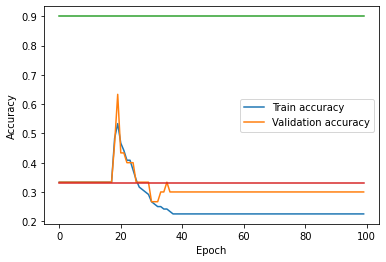

Training accuracy 0.225
Validation accuracy 0.3


In [ ]:
model = FFN(n_inputs= X_train.shape[1], n_outputs=y_OH_train.shape[1], hidden_layers=[1], activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=100, eta=0.5)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


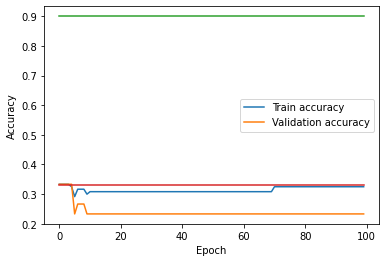

Training accuracy 0.325
Validation accuracy 0.2333


In [ ]:
model = FFN(n_inputs= X_train.shape[1], n_outputs=y_OH_train.shape[1], hidden_layers=[2], activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=100, eta=0.5)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


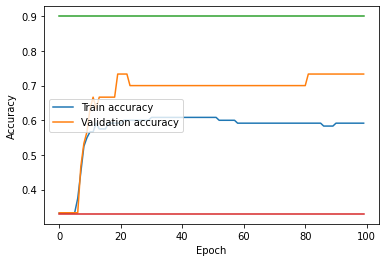

Training accuracy 0.5917
Validation accuracy 0.7333


In [ ]:
model = FFN(n_inputs= X_train.shape[1], n_outputs=y_OH_train.shape[1], hidden_layers=[4], activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=100, eta=0.25)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


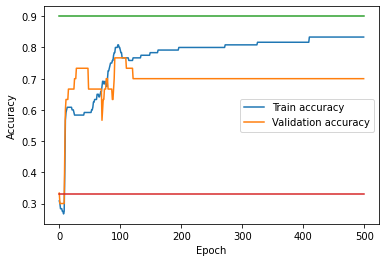

Training accuracy 0.8333
Validation accuracy 0.7


In [ ]:
model = FFN(n_inputs= X_train.shape[1], n_outputs=y_OH_train.shape[1], hidden_layers=[32], activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, l2_norm=False, display_loss=False)
print_accuracy()

High Variance

# Adding L2 Regularisation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


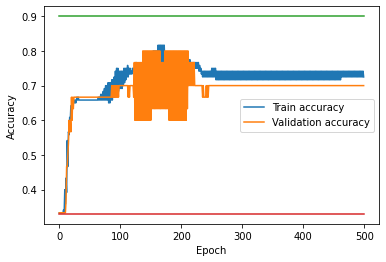

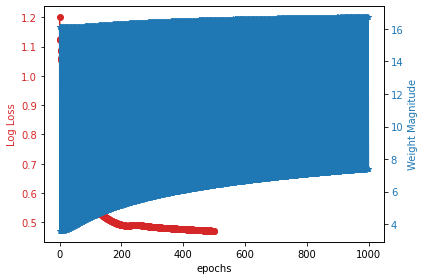

Training accuracy 0.725
Validation accuracy 0.7


In [ ]:
model = FFN(n_inputs= X_train.shape[1], n_outputs=y_OH_train.shape[1], hidden_layers=[64], activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()